In [110]:
from __future__ import division
from ADMCode import visualize as vis
from ADMCode import ddm, sdt

import numpy as np
import pandas as pd

from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline

## Signal Detection Theory

In [111]:
interactive_plot = interactive(vis.sdt_interact, Hits=(0,100,5), Misses=(0,100,5), CR=(0,100,5), FA=(0,100,5))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(IntSlider(value=100, description='Hits', step=5), IntSlider(value=100, description='Misses', step=5), IntSlider(value=100, description='CR', step=5), IntSlider(value=0, description='FA', step=5), Output(layout=Layout(height='300px'))), _dom_classes=('widget-interact',))

## DDM Parameters

In [112]:
a = .10 # boundary height
v = .14 # strong drift-rate
tr = .25 # nondecision time (in seconds)
z = .5 # starting point ([0,1], fraction of a)

dt = .001 # time stepsize
si = .1 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence stepsize (up/down)
deadline = 1.75 # max decision time (in sec)
ntrials = 1000 # number of trials to simulate

parameters = np.array([a, tr, v, z, si, dx, dt])

## Simulate DDM

In [113]:
df, traces = ddm.sim_ddm_trials(parameters, ntrials, deadline)
df.head()

,trial,rt,choice
0,1,0.594,1.0
1,2,0.354,0.0
2,3,0.464,1.0
3,4,0.674,1.0
4,5,0.674,1.0


## Analyze simulated behavior

In [114]:
accuracy = df.choice.mean()
corRT = df[df.choice==1].rt.mean()
errRT = df[df.choice==0].rt.mean()

print("RT (cor) = {:.0f} ms".format(corRT/dt))
print("RT (err) = {:.0f} ms".format(errRT/dt))
print("Accuracy = {:.0f}%".format(accuracy*100))

RT (cor) = 472 ms
RT (err) = 487 ms
Accuracy = 80%


## Plot evidence traces

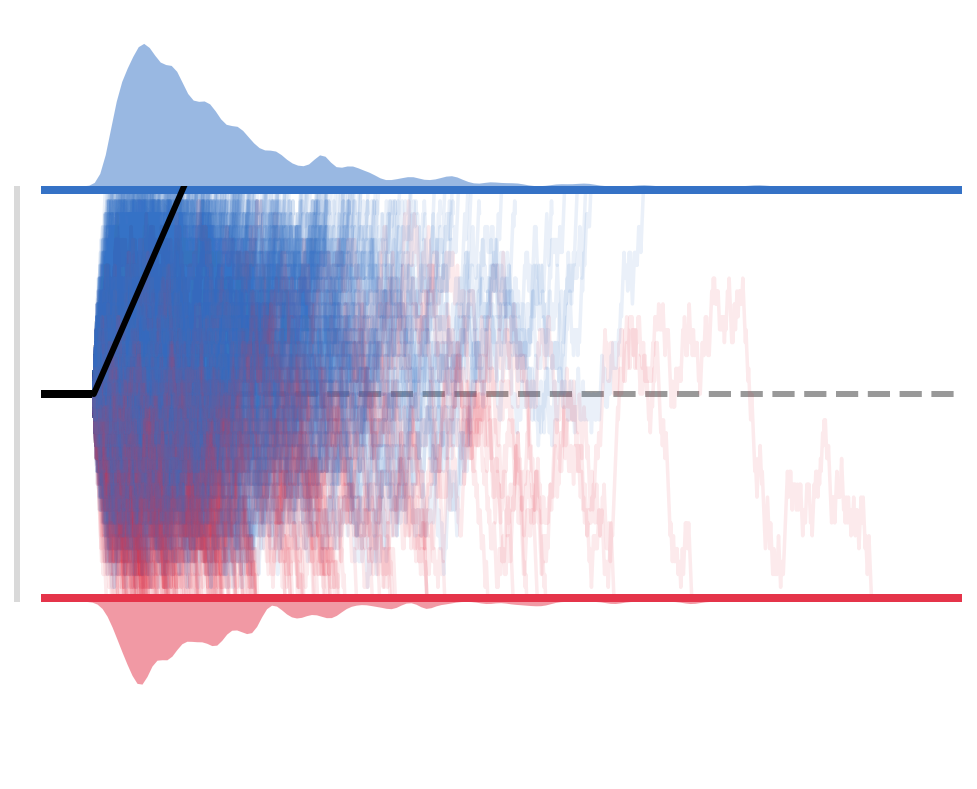

In [115]:
ax = vis.plot_ddm_sims(df, parameters, traces=traces, plot_v=True)

### Use DDM to simulate Yes/No experiment

In [106]:
a = .16 # boundary height
tr = .25 # nondecision time (in seconds)
z = .5 # starting point ([0,1], fraction of a)

vSignal = .18 # drift-rate on signal trials
vNoise = -.1 # drift-rate on noise-only trials

sigParams = np.array([a, tr, vSignal, z, si, dx, dt])
noiseParams = np.array([a, tr, vNoise, z, si, dx, dt])
plist = [sigParams, noiseParams]

In [107]:
sdtData, traces = ddm.ddm_sim_yesno(plist, ntrials, deadline)

In [108]:
sdt.analyze_yesno(sdtData)

Signal Accuracy = 95%
	Hits = 935
	Misses = 52

Noise Accuracy = 83%
	Corr. Rej. = 787
	False Alarms = 157

d-prime (d') = 2.59
criterion (c) = -0.33


## Compare $v_{signal}$ and $v_{noise}$ RTs 

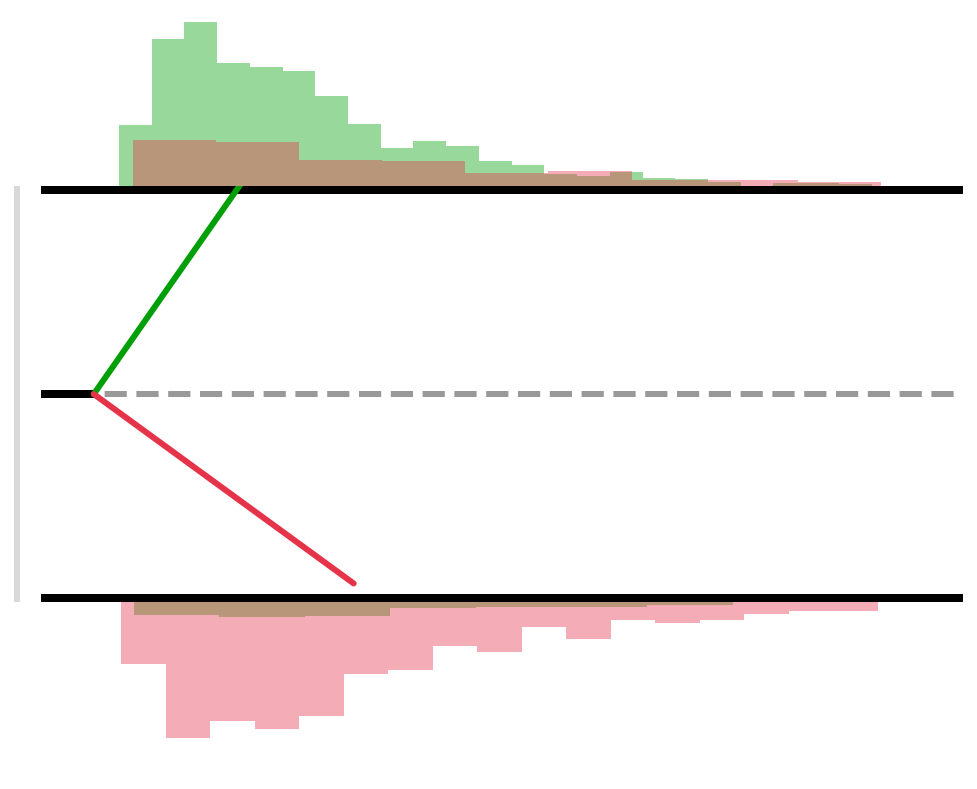

In [109]:
ax = vis.compare_drift_effects(sdtData, plist)